In [2]:
import os
import csv
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D

Using TensorFlow backend.


In [3]:
def read_csv(directory):
    with open(directory + '/driving_log.csv', 'r') as csvfile:
        lines = []
        reader = csv.reader(csvfile)
        
        for i, line in enumerate(reader):
            if i != 0:
                lines.append(line)
    
        return lines
    
def load_image(source_path):
    file_dir = source_path.split('/')[-4:-1]
    filename = source_path.split('/')[-1]
    path = os.path.join(*file_dir) + '/' + filename
    image = cv2.imread(path)
    image = image[60:140, :, :] # y1:y2, x1:x2
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image,(200, 66), interpolation = cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    
    return image.astype(np.uint8)

def build_generator(files, steerings, batch_size):
    while True:
        X = np.zeros((0, 66, 200, 3), dtype=np.uint8)
        y = np.zeros((0, 1), dtype=np.float16)

        for i in range(batch_size):
            idx = np.random.choice(len(files), 1)[0]
            feature = load_image(files[idx])
            X = np.append(X, feature[None,:], axis=0)
            flipped_feature = cv2.flip(feature, 1)
            X = np.append(X, flipped_feature[None,:], axis=0)
            
            label = steerings[idx]
            y = np.append(y, label)
            y = np.append(y, -1 * label)
        
        yield shuffle(X, y)
        
def remove_low_steering(files, steerings):
    filtered_files = []
    filtered_steerings = []
    
    for idx, steering in enumerate(steerings):
        if abs(steering) >= 0.15:
            filtered_files.append(files[idx])
            filtered_steerings.append(steering)
        else:
            random = np.random.randint(10)
            
            if random < 10:
                filtered_files.append(files[idx])
                filtered_steerings.append(steering)

    print("Dropped {} rows with low steering".format(len(files) - len(filtered_files)))
    return filtered_files, filtered_steerings
        
def filter_bias_data(files, steerings):
    files, steerings = remove_low_steering(files, steerings)
    
    num_bins = 100
    avg_samples_per_bin = int(math.ceil(len(steerings) / num_bins))
    hist, bins = np.histogram(steerings, num_bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(steerings), np.max(steerings)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

    keep_probs = []
    target = avg_samples_per_bin * 0.2
    remove_list = []
    
    for i in range(num_bins):
        if hist[i] < target:
            keep_probs.append(1.0)
        else:
            keep_probs.append(1.0 / (hist[i] / target))

    for i in range(len(steerings)):
        for j in range(num_bins):
            if steerings[i] > bins[j] and steerings[i] <= bins[j+1]:
                if np.random.rand() > keep_probs[j]:
                    remove_list.append(i)
                    
    files_filtered = np.delete(files, remove_list, axis=0)
    steerings_filtered = np.delete(steerings, remove_list)

    hist, bins = np.histogram(steerings_filtered, num_bins)
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(steerings_filtered), np.max(steerings_filtered)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.hist(steerings, bins=num_bins)
    ax2.hist(steerings_filtered, bins=num_bins)
    plt.show()
    plt.close(f)
    
    return files_filtered, steerings_filtered
    
def load_data(directory):
    csv_lines = read_csv(directory)
#     f, ax_list = plt.subplots(1, 3, figsize=(10, 4))
    
#     for i in range(3):
#         img = load_image(csv_lines[0][i])
#         ax_list[i].imshow(img, cmap='gray')
#         ax_list[i].axis("off")

#     plt.show()
    
    return csv_lines

def split_on_batches(train_samples, valid_samples, size=32):
    train_lines_num = len(train_samples)
    train_batches = train_lines_num // size
    train_samples_num = size * train_batches
    train_csv_lines = train_samples[:train_samples_num]
    train = train_csv_lines, train_batches
    
    valid_lines_num = len(valid_samples)
    valid_batches = valid_lines_num // size
    valid_samples_num = size * valid_batches
    valid_csv_lines = valid_samples[:valid_samples_num]
    valid = valid_csv_lines, valid_batches
    
    return train, valid, size

In [4]:
def train_model(model_path, train, valid, batch_size, epochs):
    train_data, train_batches = train
    train_files, train_steerings = zip(*train_data)
    
    valid_data, valid_batches = valid
    valid_files, valid_steerings = zip(*valid_data)

    train_samples_num = len(train_files)
    train_generator = build_generator(train_files, train_steerings, batch_size)
    valid_samples_num = len(valid_files)
    valid_generator = build_generator(valid_files, valid_steerings, batch_size)

    model = None
    show_summary = False
    
    if Path(model_path + ".json").is_file():
        with open(model_path + ".json", "r") as json_file:
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(model_path + ".h5")
            print("Loaded model from disk")
    else:
        show_summary = True
        
    if model is None:
        print("Create new model")
        model = Sequential()
        model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(66,200,3)))

        model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid'))
        model.add(ELU())
        model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid'))
        model.add(ELU())
        model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid'))
        model.add(ELU())
        model.add(Convolution2D(64, 3, 3, border_mode='valid'))
        model.add(ELU())
        model.add(Convolution2D(64, 3, 3, border_mode='valid'))
        model.add(ELU())
        model.add(Dropout(0.4))
        
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(ELU())
        
        model.add(Dense(100))
        model.add(ELU())

        model.add(Dense(50))
        model.add(ELU())

        model.add(Dense(10))
        model.add(ELU())

        model.add(Dense(1))
    
    optimizer = Adam(lr=1e-4)
    model.compile(loss='mse', optimizer=optimizer)

    history = model.fit_generator(train_generator, samples_per_epoch=2*train_samples_num, validation_data=valid_generator, nb_val_samples=2*valid_samples_num, nb_epoch=epochs, verbose=1)
    print(history.history)
    
    model.save_weights(model_path + ".h5")
    model_json = model.to_json()
    with open(model_path + ".json", "w") as json_file:
        json_file.write(model_json)

    if show_summary:
        model.summary()

Dropped 0 rows with low steering


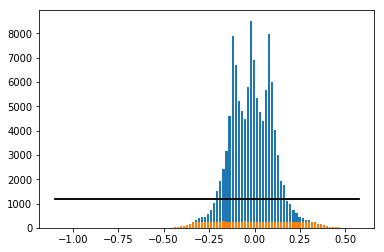

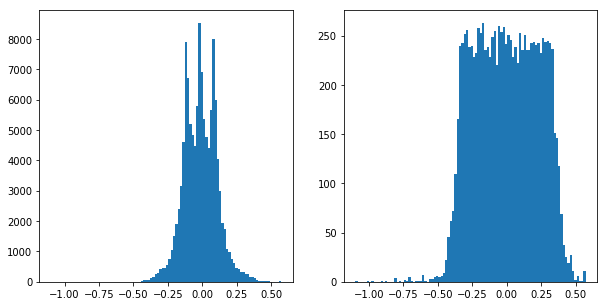

Loaded model from disk
Epoch 1/5
17792/17792 [==============================] - 340s - loss: 0.0026 - val_loss: 0.0031
Epoch 2/5
17792/17792 [==============================] - 233s - loss: 0.0022 - val_loss: 0.0027
Epoch 3/5
17792/17792 [==============================] - 233s - loss: 0.0021 - val_loss: 0.0035
Epoch 4/5
17792/17792 [==============================] - 234s - loss: 0.0020 - val_loss: 0.0024
Epoch 5/5
17792/17792 [==============================] - 234s - loss: 0.0019 - val_loss: 0.0023
{'loss': [0.0025704284581747712, 0.0021678292123004524, 0.0020827027609347359, 0.0019999569195671102, 0.0018947154615181598], 'val_loss': [0.0030642682568345599, 0.0026799094157995305, 0.0035107017889537888, 0.0023683348436084025, 0.0022933791590638566]}
Dropped 0 rows with low steering


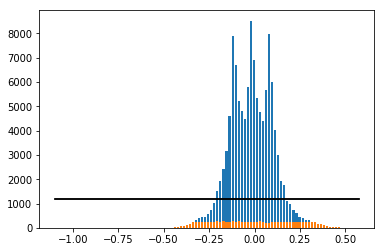

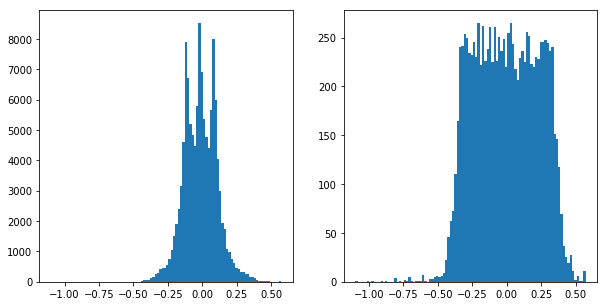

Loaded model from disk
Epoch 1/5
17536/17536 [==============================] - 280s - loss: 0.0019 - val_loss: 0.0028
Epoch 2/5
17536/17536 [==============================] - 254s - loss: 0.0020 - val_loss: 0.0022
Epoch 3/5
17536/17536 [==============================] - 255s - loss: 0.0021 - val_loss: 0.0026
Epoch 4/5
17536/17536 [==============================] - 231s - loss: 0.0019 - val_loss: 0.0018
Epoch 5/5
17536/17536 [==============================] - 230s - loss: 0.0019 - val_loss: 0.0018
{'loss': [0.0019471668034968695, 0.0020091160175893592, 0.0020782100984208067, 0.0019468685705979511, 0.0019111761391625134], 'val_loss': [0.0027579407632241353, 0.0022333711882204037, 0.0026030171600937404, 0.0018342717915348819, 0.0017908176352434298]}
Dropped 0 rows with low steering


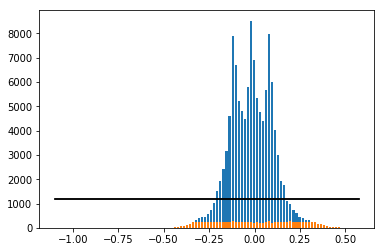

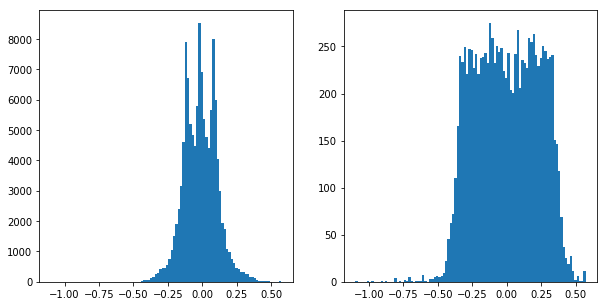

Loaded model from disk
Epoch 1/5
17472/17472 [==============================] - 250s - loss: 0.0020 - val_loss: 0.0022
Epoch 2/5
17472/17472 [==============================] - 252s - loss: 0.0019 - val_loss: 0.0022
Epoch 3/5
17472/17472 [==============================] - 239s - loss: 0.0018 - val_loss: 0.0019
Epoch 4/5
17472/17472 [==============================] - 222s - loss: 0.0017 - val_loss: 0.0020
Epoch 5/5
17472/17472 [==============================] - 221s - loss: 0.0018 - val_loss: 0.0020
{'loss': [0.0019820088187178031, 0.0019353981014262652, 0.0017905625821289098, 0.0017389589698896522, 0.0018251177941401226], 'val_loss': [0.0022426532694439895, 0.0021772591058192227, 0.0018811737690531813, 0.0019747967513360303, 0.002032871717614505]}
Dropped 0 rows with low steering


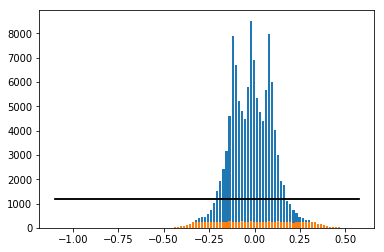

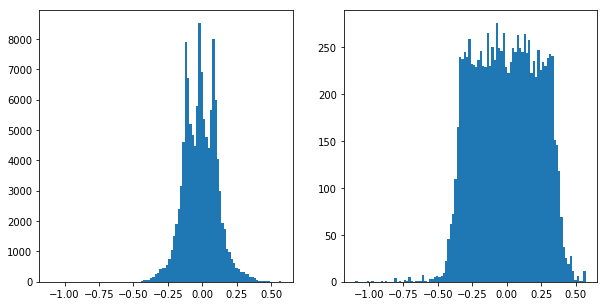

Loaded model from disk
Epoch 1/5
17728/17728 [==============================] - 242s - loss: 0.0019 - val_loss: 0.0021
Epoch 2/5
17728/17728 [==============================] - 227s - loss: 0.0019 - val_loss: 0.0021
Epoch 3/5
17728/17728 [==============================] - 232s - loss: 0.0019 - val_loss: 0.0021
Epoch 4/5
17728/17728 [==============================] - 225s - loss: 0.0018 - val_loss: 0.0016
Epoch 5/5
17728/17728 [==============================] - 225s - loss: 0.0017 - val_loss: 0.0017
{'loss': [0.0019015701658290807, 0.0018923328361484064, 0.0019275647752400528, 0.0018279675389253384, 0.0017313329204126844], 'val_loss': [0.0020983843385930295, 0.0020702865187321668, 0.002142412996297513, 0.0016389420581644104, 0.001735502862425494]}
Dropped 0 rows with low steering


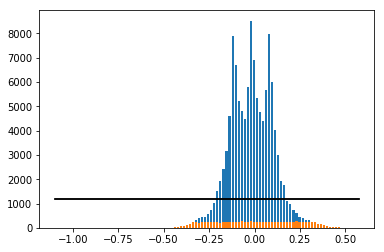

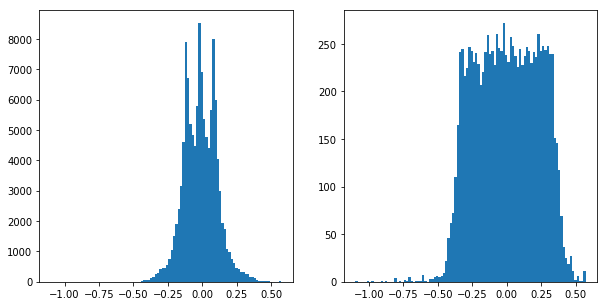

Loaded model from disk
Epoch 1/5
17600/17600 [==============================] - 233s - loss: 0.0018 - val_loss: 0.0019
Epoch 2/5
17600/17600 [==============================] - 233s - loss: 0.0018 - val_loss: 0.0019
Epoch 3/5
17600/17600 [==============================] - 231s - loss: 0.0017 - val_loss: 0.0017
Epoch 4/5
17600/17600 [==============================] - 249s - loss: 0.0016 - val_loss: 0.0021
Epoch 5/5
17600/17600 [==============================] - 234s - loss: 0.0017 - val_loss: 0.0024
{'loss': [0.0017971529055979441, 0.0018146860025907781, 0.0016709335643628781, 0.00163537036775696, 0.0016709596826694907], 'val_loss': [0.0019265715895658907, 0.0018875391225960543, 0.0017062691588173894, 0.0020865123010213103, 0.0023992457940681454]}
Dropped 0 rows with low steering


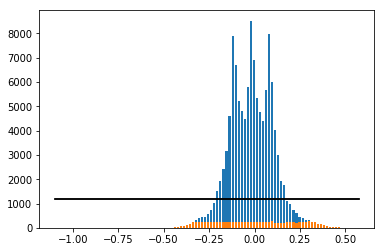

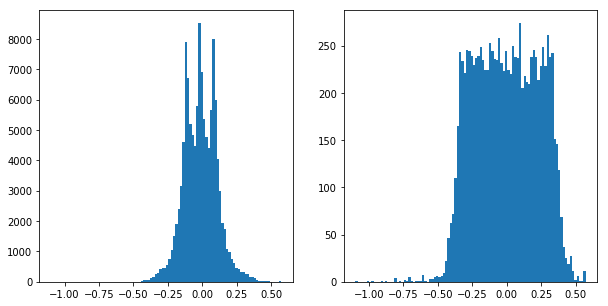

Loaded model from disk
Epoch 1/5
17280/17280 [==============================] - 227s - loss: 0.0019 - val_loss: 0.0020
Epoch 2/5
17280/17280 [==============================] - 230s - loss: 0.0018 - val_loss: 0.0020
Epoch 3/5
17280/17280 [==============================] - 245s - loss: 0.0017 - val_loss: 0.0017
Epoch 4/5
17280/17280 [==============================] - 303s - loss: 0.0018 - val_loss: 0.0020
Epoch 5/5
17280/17280 [==============================] - 279s - loss: 0.0016 - val_loss: 0.0018
{'loss': [0.0018812000313859986, 0.001797372568614298, 0.0016618717537278793, 0.0017561080406368194, 0.0016065163453782183], 'val_loss': [0.0020355124759779716, 0.0019963719923772028, 0.0017304289234635322, 0.0020056860921070425, 0.0018067634212714967]}
Dropped 0 rows with low steering


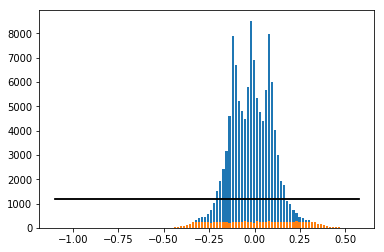

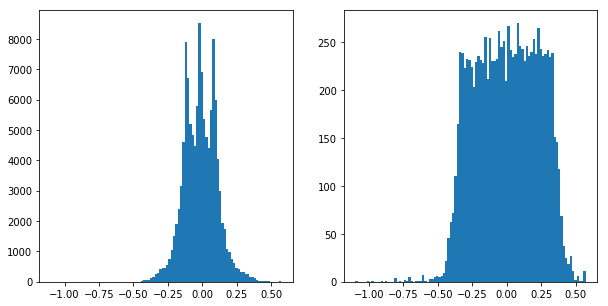

Loaded model from disk
Epoch 1/5
17472/17472 [==============================] - 256s - loss: 0.0018 - val_loss: 0.0019
Epoch 2/5
17472/17472 [==============================] - 261s - loss: 0.0017 - val_loss: 0.0017
Epoch 3/5
17472/17472 [==============================] - 250s - loss: 0.0016 - val_loss: 0.0020
Epoch 4/5
17472/17472 [==============================] - 235s - loss: 0.0016 - val_loss: 0.0018
Epoch 5/5
17472/17472 [==============================] - 233s - loss: 0.0016 - val_loss: 0.0019
{'loss': [0.0017509853178225866, 0.0017034561079483303, 0.0015919288006720335, 0.0016329629654184175, 0.0015504881682048377], 'val_loss': [0.0018635202038293594, 0.0016889344996717922, 0.0019652338917641077, 0.0018107820685733767, 0.0018644283152431907]}
Dropped 0 rows with low steering


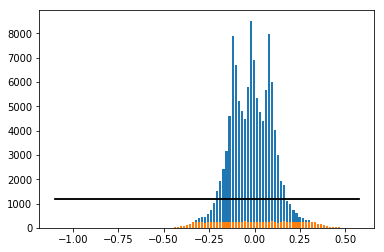

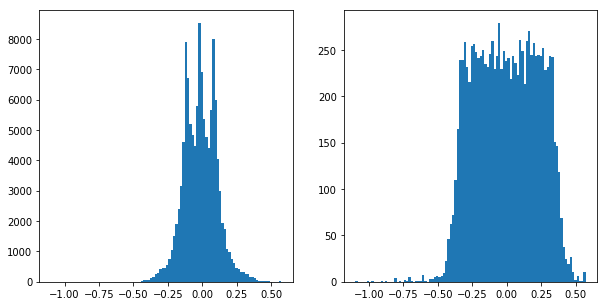

Loaded model from disk
Epoch 1/5
17792/17792 [==============================] - 235s - loss: 0.0017 - val_loss: 0.0021
Epoch 2/5
17792/17792 [==============================] - 239s - loss: 0.0016 - val_loss: 0.0019
Epoch 3/5
17792/17792 [==============================] - 245s - loss: 0.0016 - val_loss: 0.0019
Epoch 4/5
17792/17792 [==============================] - 247s - loss: 0.0015 - val_loss: 0.0026
Epoch 5/5
17792/17792 [==============================] - 245s - loss: 0.0016 - val_loss: 0.0024
{'loss': [0.0016720619608762025, 0.0015759170419710736, 0.0015523671838387901, 0.0015492983984848041, 0.001590304907910499], 'val_loss': [0.0020876272557897196, 0.0019124798768577907, 0.0018787758485616548, 0.0025789290784682698, 0.0023917030202278838]}
Dropped 0 rows with low steering


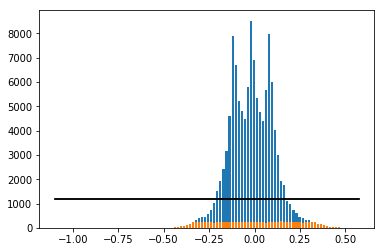

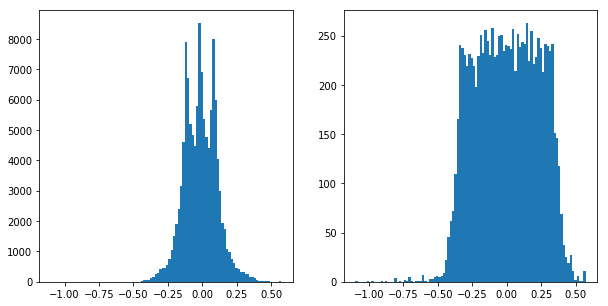

Loaded model from disk
Epoch 1/5
17408/17408 [==============================] - 249s - loss: 0.0017 - val_loss: 0.0018
Epoch 2/5
17408/17408 [==============================] - 253s - loss: 0.0017 - val_loss: 0.0020
Epoch 3/5
17408/17408 [==============================] - 240s - loss: 0.0017 - val_loss: 0.0017
Epoch 4/5
17408/17408 [==============================] - 250s - loss: 0.0016 - val_loss: 0.0018
Epoch 5/5
17408/17408 [==============================] - 238s - loss: 0.0016 - val_loss: 0.0018
{'loss': [0.0017343592012099072, 0.0017231649754274473, 0.0017193241994177429, 0.0015807059205732966, 0.0016406897942515036], 'val_loss': [0.0017617333779686734, 0.001954444940886734, 0.0017144572972456979, 0.0017885977945030283, 0.0018226541048052775]}
Dropped 0 rows with low steering


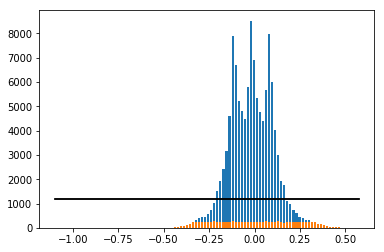

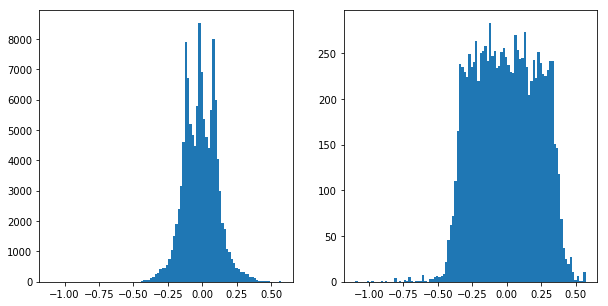

Loaded model from disk
Epoch 1/5
17664/17664 [==============================] - 267s - loss: 0.0016 - val_loss: 0.0016
Epoch 2/5
17664/17664 [==============================] - 261s - loss: 0.0017 - val_loss: 0.0019
Epoch 3/5
17664/17664 [==============================] - 264s - loss: 0.0016 - val_loss: 0.0017
Epoch 4/5
17664/17664 [==============================] - 263s - loss: 0.0016 - val_loss: 0.0019
Epoch 5/5
17664/17664 [==============================] - 275s - loss: 0.0015 - val_loss: 0.0017
{'loss': [0.0016481900223669177, 0.0016909843431768832, 0.0016135483247521536, 0.0015981043528670957, 0.0015458375910647969], 'val_loss': [0.0015700017296088238, 0.0019116799703097322, 0.0017406958479272282, 0.0018792690471341105, 0.0016766855251921368]}
We're done


In [5]:
for i in range(10):
    files = []
    steerings = []
    # directories = ["Track1.1", "Track1.2", "Track1.3", "Track1.4", "Track1.5", "Track1.6", 
    #                "Track1.7 - left border","Track1.8 - borders", "Track1.9 - full", "Track1.9.1 - full", 
    #                "Track1.9.2 - full", "Track1.9.3 - full", "Track1.9.4 - full", "Track2", 
    #                "Track2.1 - full", "Track2.2 - full"]

#     directories = ["Track1.9.2 - full", "Track2.1 - full"]
#     directories = ["Track1.9.1 - full", "Track2"]
    directories = ["Track1.3", "Track1.4", "Track1.5", "Track1.9.1 - full", "Track1.9.2 - full", "Track1.9.3 - full", "Track1.9.4 - full"]
#     directories = ["Track1.3", "Track1.4", "Track1.5"]
    steering_offsets = [0.0, 0.1, -0.1] # center, left, right

    for directory in directories:
        lines = load_data("data/" + directory)

        for line in lines:
            for idx, offset in enumerate(steering_offsets):
                offset = float(line[3]) + steering_offsets[idx]
                steerings.append(offset)
                files.append(line[idx])

    files, steerings = filter_bias_data(files, steerings)

    train_samples, valid_samples = train_test_split(list(zip(files, steerings)), test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model("model/p3_model", train, valid, size, epochs=5)
    
print("We're done")